# Sporozoite traversal in monocytes

In [15]:
library(Seurat)
library(patchwork)
library(readxl)
library(tidyverse)
library(ggplot2)
library(ggpubr)
library(reshape2)
library(broom)
library(stringr)
library(ggplot2)
library(cowplot)
library(RColorBrewer)
library(Azimuth)

In [16]:
lib_name = "EXP1_l1"

In [ ]:
samplesheet <- read.delim("../Data/01_sample_metadata.csv")

# Antibody column needs to be changed from Total_Seq to TotalSeq
samplesheet <- samplesheet %>% 
  mutate(Antibody = gsub("Total_Seq", "TotalSeq", MultiplexTag))

head(samplesheet)

In [40]:
hto_used = samplesheet %>%
    filter(Library_name == lib_name) %>%
    pull(Antibody) %>%
    unique

hto_used

[1] "TotalSeq_A_6" "TotalSeq_A_9" "TotalSeq_A_7" "TotalSeq_A_8"

In [75]:
data <- Read10X(data.dir = paste0("../counts/",lib_name,"/filtered_feature_bc_matrix/"))
gex <- data[[1]]
hto <- data[[2]][rownames(data[[2]]) %in% hto_used, ]

mono <- CreateSeuratObject(counts = gex, project = lib_name, min.cells = 3, min.features = 50)
mono
mono[["percent.mt"]] <- PercentageFeatureSet(mono, pattern = "^MT-")
head(mono@meta.data, 5)

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


An object of class Seurat 
26068 features across 14311 samples within 1 assay 
Active assay: RNA (26068 features, 0 variable features)
 1 layer present: counts

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCAAGACAACTA-1,EXP1_l1,1659,884,4.701627
AAACCCAAGGTTCTAC-1,EXP1_l1,1421,804,6.896552
AAACCCAAGTTGCTGT-1,EXP1_l1,1179,690,10.347752
AAACCCACACGGCTAC-1,EXP1_l1,1817,961,7.980187
AAACCCACAGCTTTGA-1,EXP1_l1,4486,1815,5.862684


## Assign donor to cells - singlets, doublets, negatives using vireo

In [76]:
mono.demul <- mono
snp <- read.delim(paste("../counts/",lib_name,"/vireo_result/donor_ids.tsv", sep = ""))
mono.demul@meta.data <- mono.demul@meta.data %>% 
  tibble::rownames_to_column("cell") %>% 
  left_join(snp) %>% 
  tibble::column_to_rownames("cell")

table(mono.demul$donor_id)

Joining with `by = join_by(cell)`



    donor0     donor1    doublet unassigned 
      7047       1231       5324        709 

In [77]:
Idents(mono.demul) <- "donor_id"
mono.demul <- subset(x = mono.demul, idents = c("doublet", "unassigned"), invert = T)

mono <- mono.demul
table(mono$donor_id)


donor0 donor1 
  7047   1231 

## Identify cells with tagged barcodes (# of barcodes (Ab) = # of donors)

In [78]:
mono.singlet.donor <- mono
joint.bcs <- intersect(rownames(mono.singlet.donor@meta.data), colnames(hto))

In [79]:
# Subset RNA and HTO counts by joint cell barcodes
#pbmc@assays$RNA <- pbmc@assays$RNA[, joint.bcs]
mono.hto <- as.matrix(hto[,joint.bcs])

# Add HTO data as a new assay independent from RNA
mono.singlet.donor[["HTO"]] <- CreateAssayObject(counts = mono.hto)

# Normalize HTO data, here we use centered log-ratio (CLR) transformation
mono.singlet.donor <- NormalizeData(mono.singlet.donor, assay = "HTO", normalization.method = "CLR")

#mono.singlet.donor <- HTODemux(mono.singlet.donor, assay = "HTO") #, positive.quantile = 0.99
mono.singlet.donor <- MULTIseqDemux(mono.singlet.donor, assay = "HTO")

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Normalizing across features




                 Negative              TotalSeq-A-6 TotalSeq-A-6_TotalSeq-A-6 
                     6177                      1006                         1 
TotalSeq-A-6_TotalSeq-A-8 TotalSeq-A-6_TotalSeq-A-9              TotalSeq-A-7 
                        6                         5                        24 
             TotalSeq-A-8 TotalSeq-A-8_TotalSeq-A-8 TotalSeq-A-8_TotalSeq-A-9 
                      789                         3                         5 
             TotalSeq-A-9 TotalSeq-A-9_TotalSeq-A-9 
                      261                         1 

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."


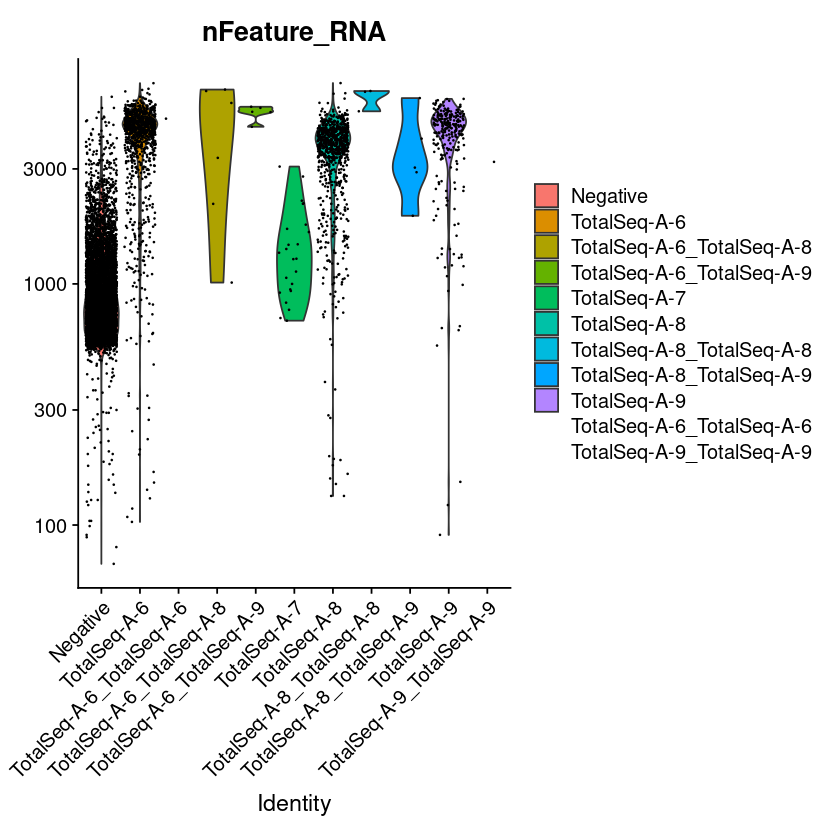

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."
Warning message:
"Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes."


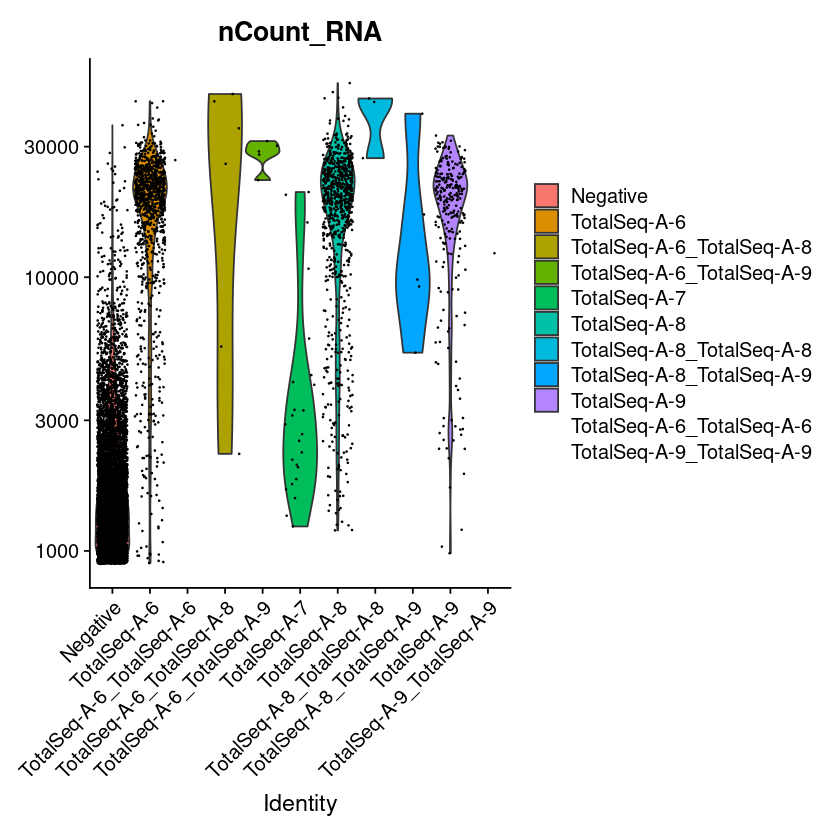

Warning message in print.DimReduc(x = reduction.data, dims = ndims.print, nfeatures = nfeatures.print):
"Only 4 dimensions have been computed."
Warning message:
"Requested number is larger than the number of available items (4). Setting to 4."
Warning message:
"Requested number is larger than the number of available items (4). Setting to 4."
Warning message:
"Requested number is larger than the number of available items (4). Setting to 4."
Warning message:
"Requested number is larger than the number of available items (4). Setting to 4."
PC_ 1 
Positive:  TotalSeq-A-6, TotalSeq-A-7 
Negative:  TotalSeq-A-8, TotalSeq-A-9 
PC_ 2 
Positive:  TotalSeq-A-9, TotalSeq-A-7 
Negative:  TotalSeq-A-8, TotalSeq-A-6 
PC_ 3 
Positive:  TotalSeq-A-7, TotalSeq-A-6 
Negative:  TotalSeq-A-8, TotalSeq-A-9 
PC_ 4 
Positive:  TotalSeq-A-6, TotalSeq-A-8 
Negative:  TotalSeq-A-7, TotalSeq-A-9 

Warning message in `[[.DimReduc`(args$object, cells, args$dims):
"The following embeddings are not present: NA"


Read the 2101 x 4 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.11 seconds (sparsity = 0.055591)!
Learning embedding...
Iteration 50: error is 70.512932 (50 iterations in 0.29 seconds)
Iteration 100: error is 59.382199 (50 iterations in 0.21 seconds)
Iteration 150: error is 57.240023 (50 iterations in 0.20 seconds)
Iteration 200: error is 56.400586 (50 iterations in 0.21 seconds)
Iteration 250: error is 55.941037 (50 iterations in 0.20 seconds)
Iteration 300: error is 1.028171 (50 iterations in 0.20 seconds)
Iteration 350: error is 0.699663 (50 iterations in 0.20 seconds)
Iteration 400: error is 0.571617 (50 iterations in 0.19 seconds)
Iteration 450: error is 0.517902 (50 iterations in 0.19 seconds)
Iteration 500: error is 0.491018 (50 iterations in 0.19 seconds)
Iteration 550: error is 0.478913 (50 iterations in 0.19 seconds)
Iteration 600: error is 0.47

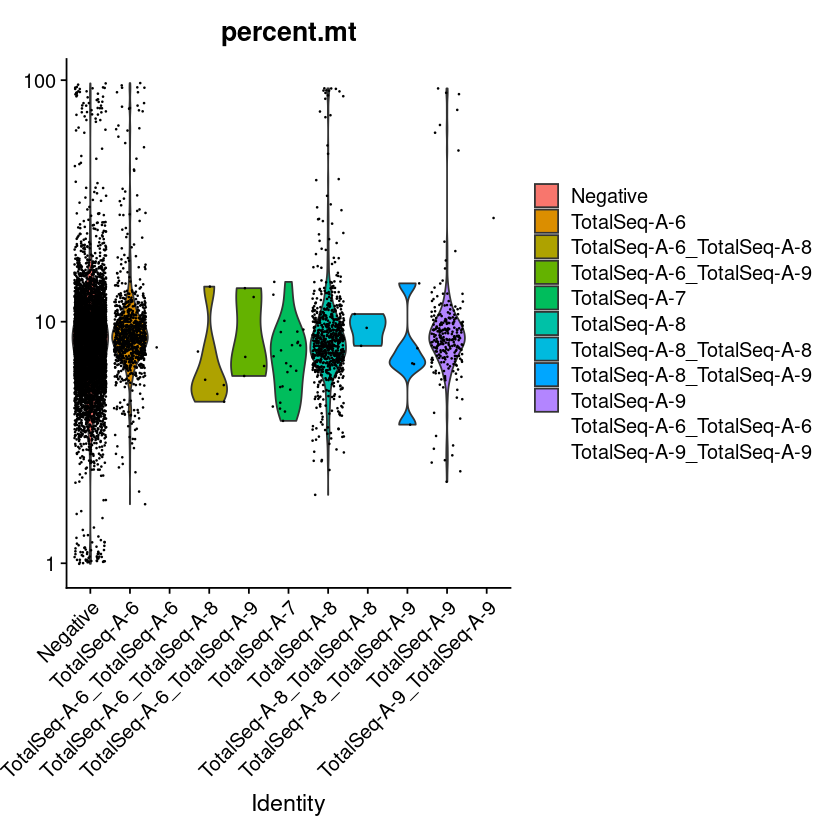

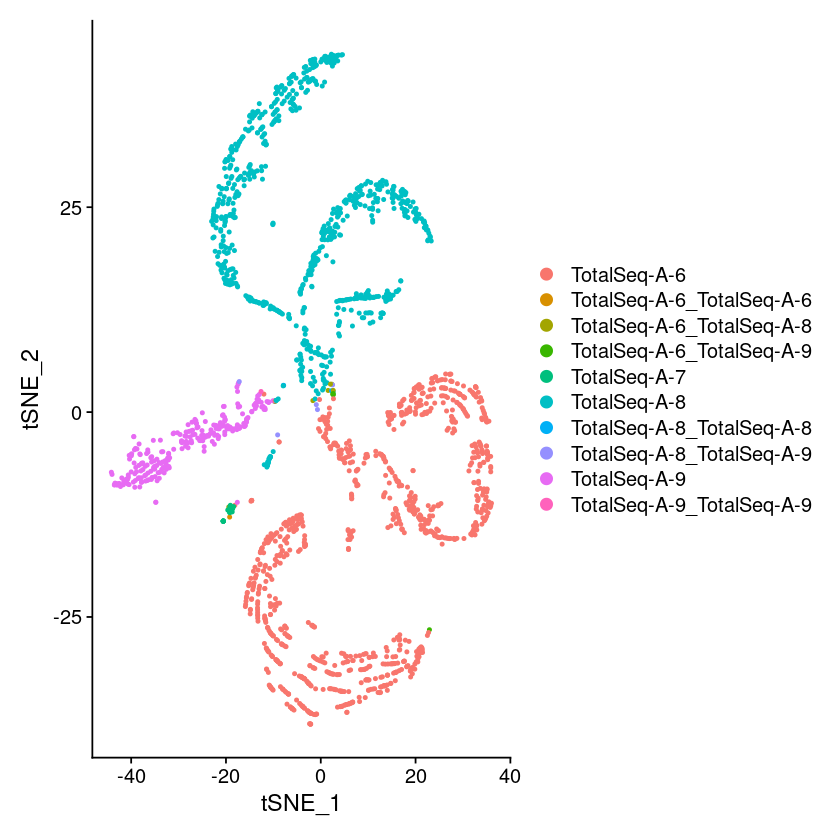

In [81]:
# Global classification results
table(mono.singlet.donor$MULTI_classification)

Idents(mono.singlet.donor) <- "MULTI_classification"
VlnPlot(mono.singlet.donor, features = c("nFeature_RNA"), pt.size = 0.1, log = TRUE)
VlnPlot(mono.singlet.donor, features = c("nCount_RNA"), pt.size = 0.1, log = TRUE)
VlnPlot(mono.singlet.donor, features = c("percent.mt"), pt.size = 0.1, log = TRUE)

mono.h <- mono.singlet.donor

# First, we will remove negative cells from the object
if(any(mono.h$MULTI_classification == "Negative") == T)
  mono.h <- subset(mono.h, idents = c("Negative"), invert = TRUE)

# Calculate a tSNE embedding of the HTO data
DefaultAssay(mono.h) <- "HTO"
mono.h <- ScaleData(mono.h, features = rownames(mono.h),
    verbose = FALSE)
mono.h <- RunPCA(mono.h, features = rownames(mono.h), approx = FALSE)
mono.h <- RunTSNE(mono.h, check_duplicates = F)
Idents(mono.h) <- 'MULTI_classification'
DimPlot(mono.h)

In [82]:
Idents(mono.singlet.donor) = "MULTI_classification"
# Extract singlets
hashtags <- gsub("Total_Seq", "TotalSeq", hto_used)
hashtags <- gsub("_", "-", hashtags)

mono.singlet.donor@meta.data <- mono.singlet.donor@meta.data %>%
  mutate(Cell_state = case_when(
    as.character(MULTI_classification) %in% hashtags ~ "Singlet",
    .default = MULTI_classification
  ))

Idents(mono.singlet.donor) <- "Cell_state"

mono.singlet <- subset(mono.singlet.donor, subset = Cell_state == "Singlet")

In [84]:
donorid <- samplesheet %>%
  filter(Library_name == lib_name) %>%
  dplyr::rename(MULTI_classification = Antibody) %>%
  mutate(MULTI_classification = gsub("_", "-", MULTI_classification)) %>%
  dplyr::rename(Group = Patient.Group) %>%
  select(Group, MULTI_classification) %>%
  distinct()

mono.demul <- mono.singlet
mono.demul@meta.data <- mono.demul@meta.data %>% 
  left_join(., donorid)

rownames(mono.demul@meta.data) <- rownames(mono.singlet@meta.data)#rownames(mono.singlet@meta.data)
mono <- mono.demul

Joining with `by = join_by(MULTI_classification)`


## Quality control

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


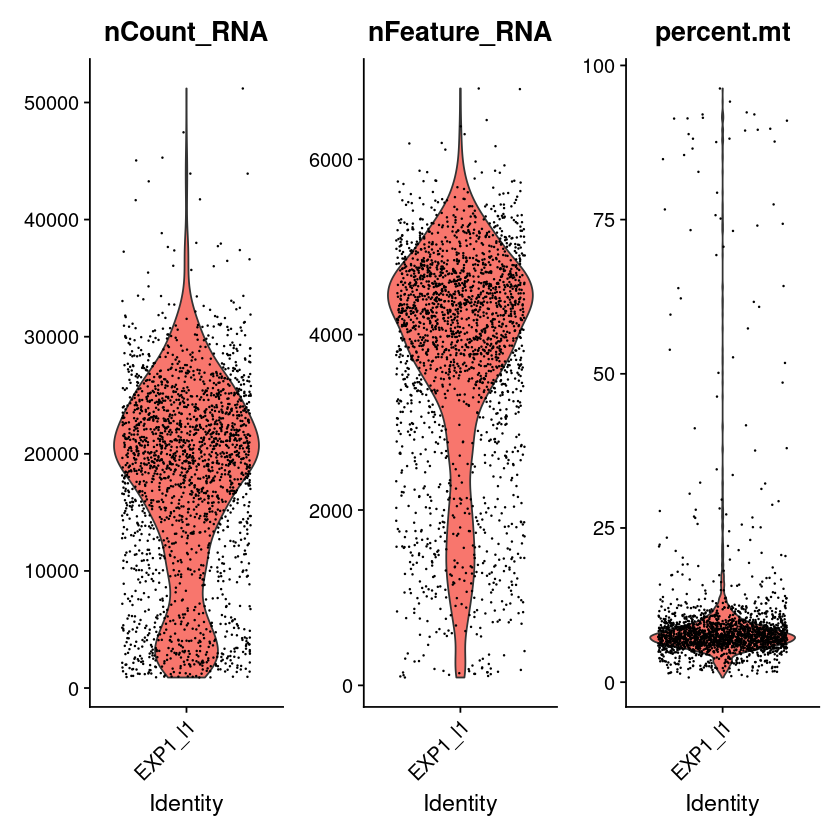

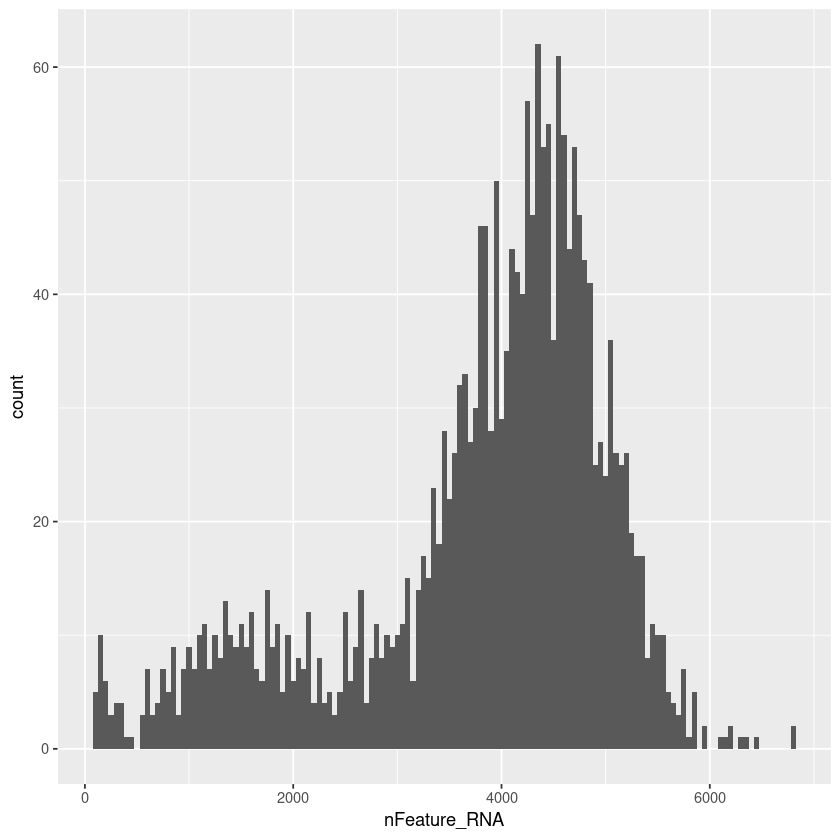

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


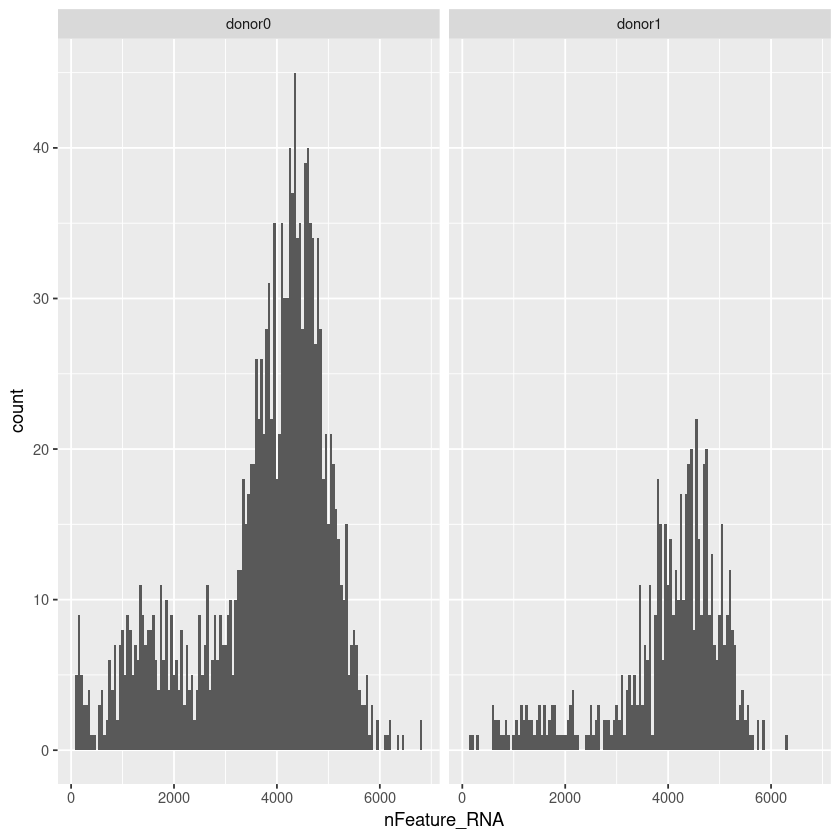

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


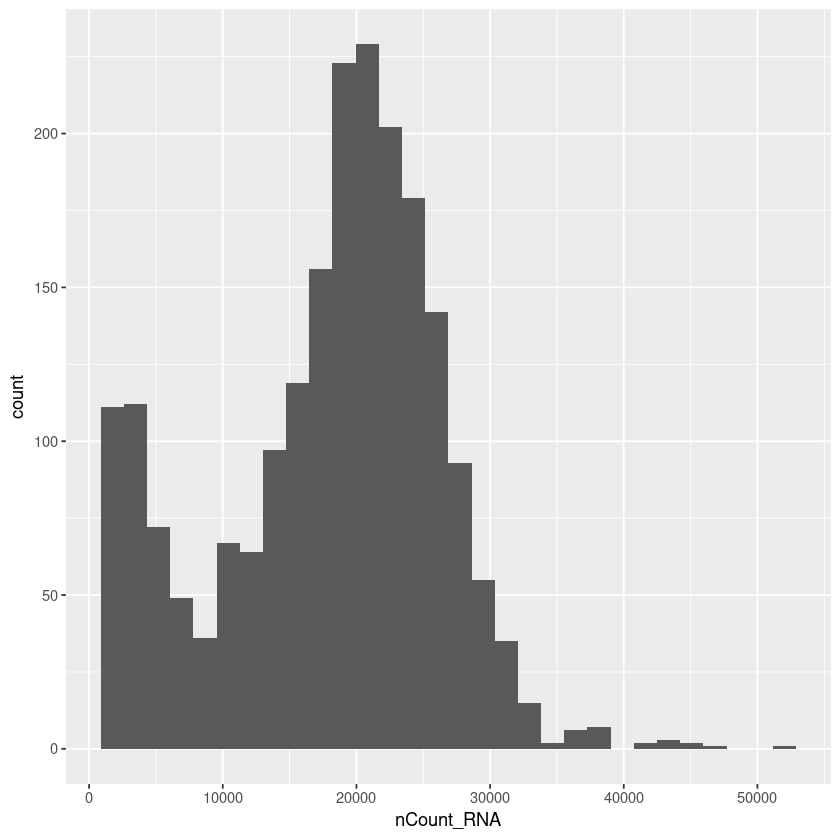

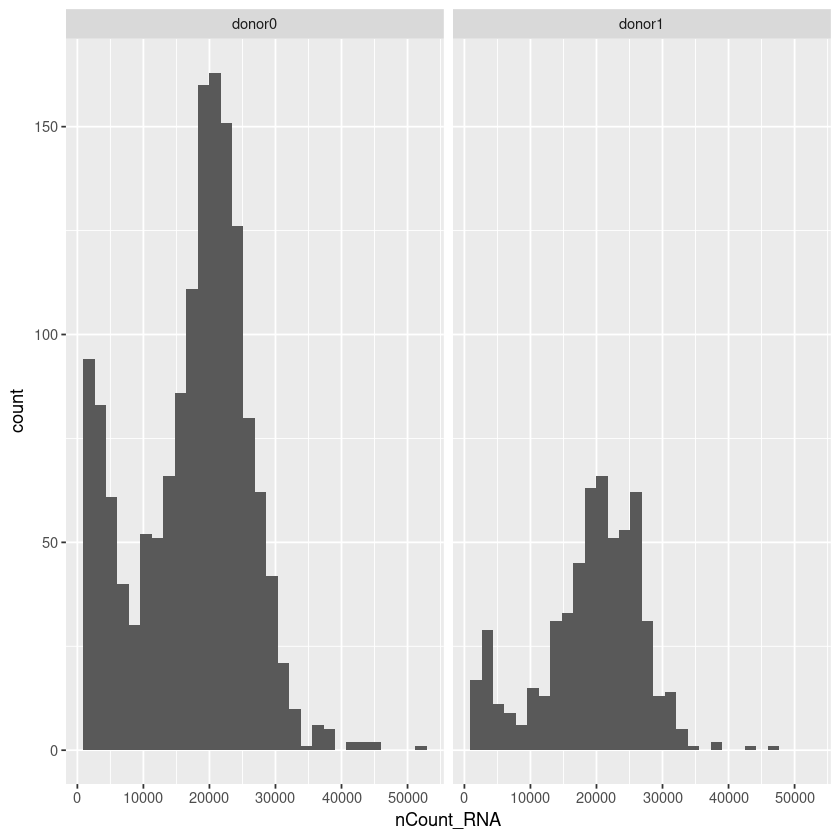

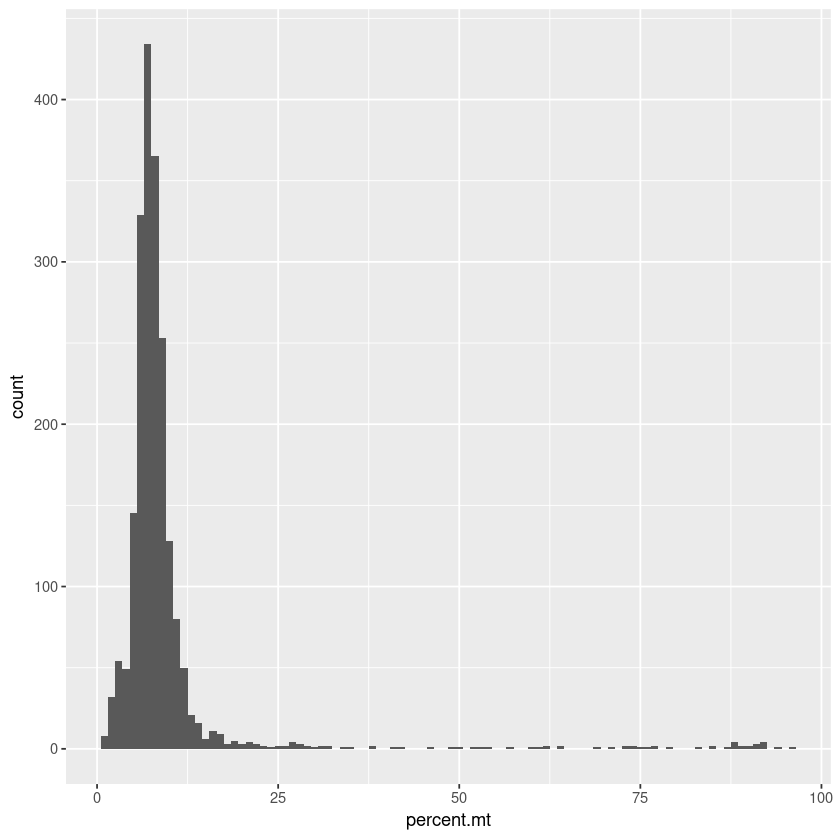

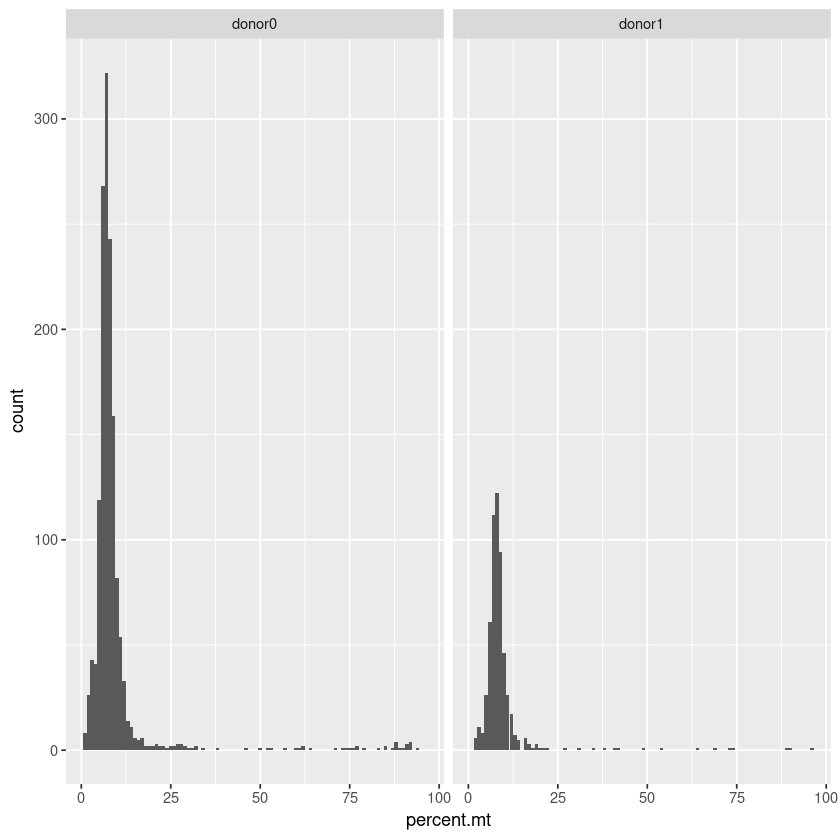

In [99]:
DefaultAssay(mono) <- "RNA"
VlnPlot(mono, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), group.by = "orig.ident") 

ggplot(mono@meta.data, aes(x = nFeature_RNA)) + geom_histogram(binwidth = 50)
ggplot(mono@meta.data, aes(x = nFeature_RNA)) + 
  geom_histogram(binwidth = 50) +
  facet_wrap( ~ donor_id)

ggplot(mono@meta.data, aes(x = nCount_RNA)) + geom_histogram()
ggplot(mono@meta.data, aes(x = nCount_RNA)) + 
  geom_histogram() +
  facet_wrap( ~ donor_id)

ggplot(mono@meta.data, aes(x = percent.mt)) + geom_histogram(binwidth = 1)
ggplot(mono@meta.data, aes(x = percent.mt)) + 
  geom_histogram(binwidth = 1) +
  facet_wrap( ~ donor_id)


FALSE  TRUE 
 1658   422 

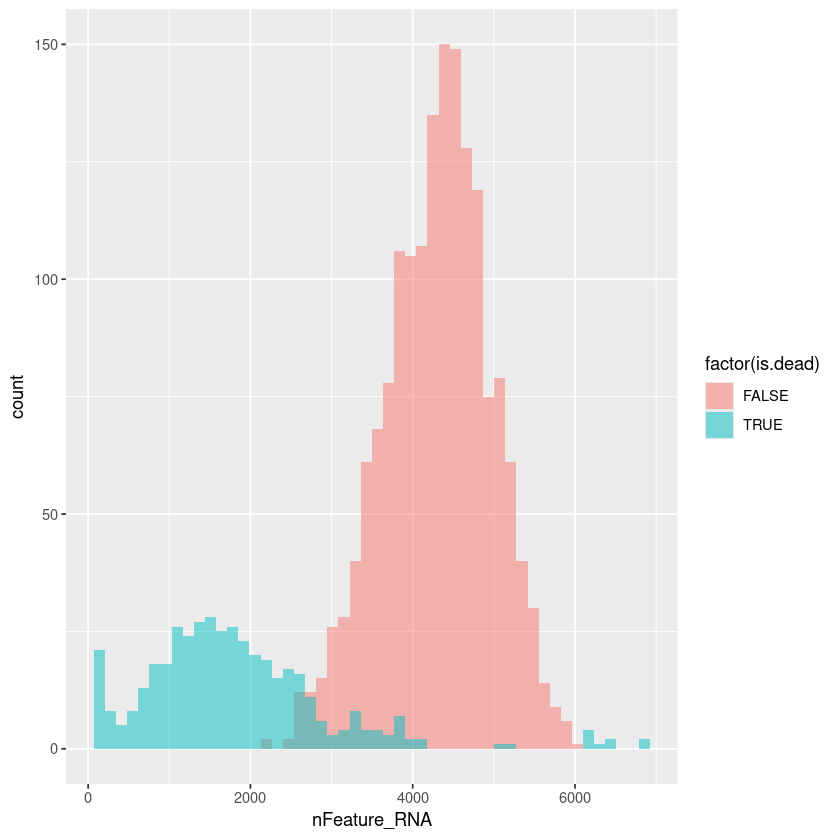

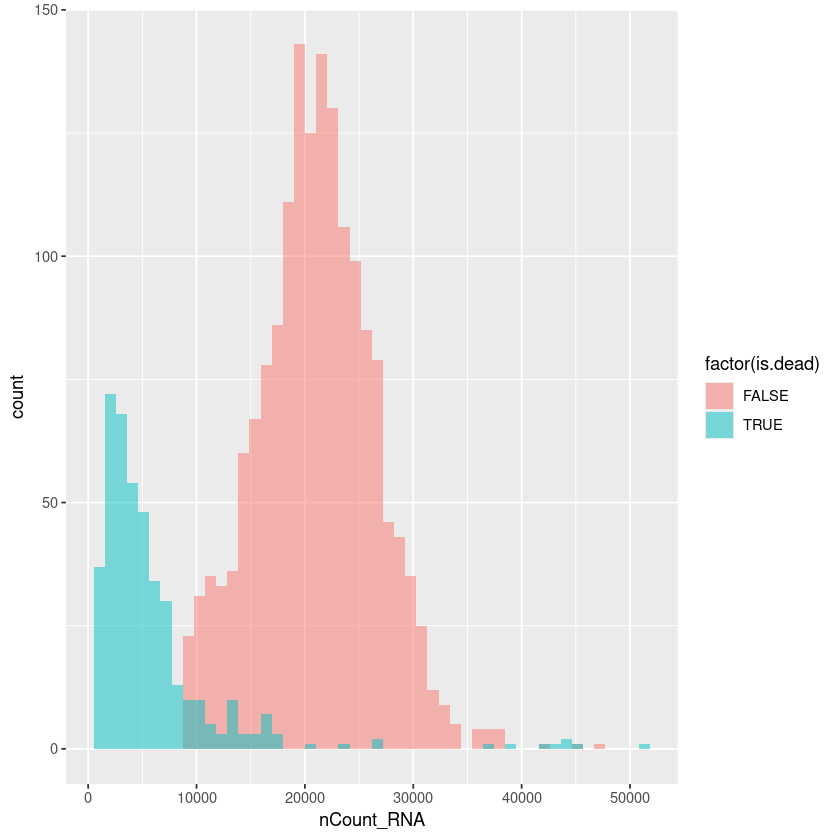

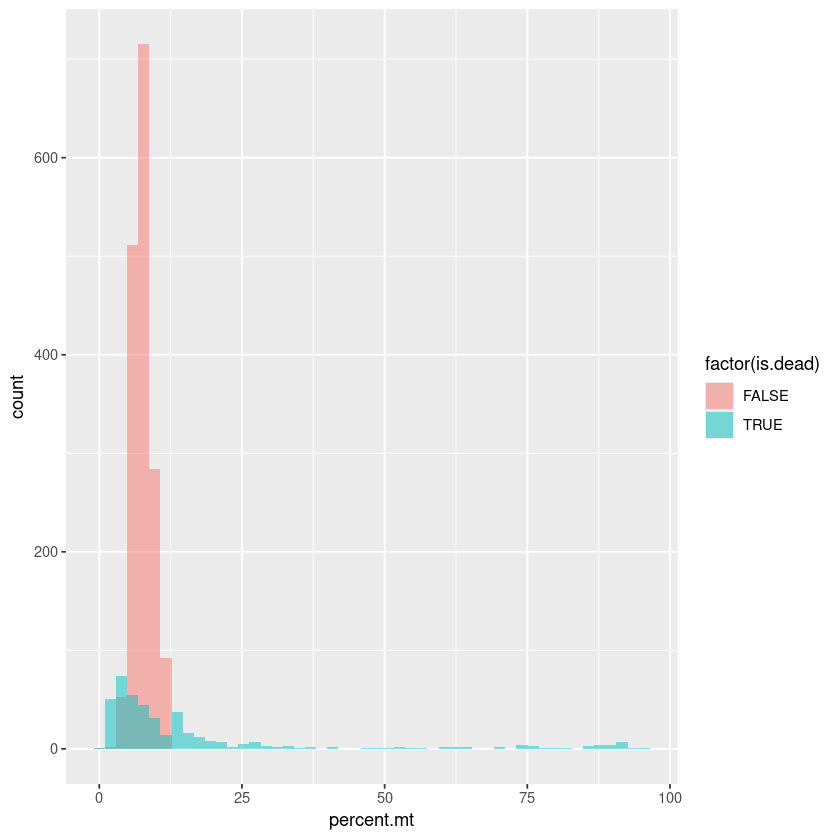

In [105]:
deadcell_nF_lowercutoff <- 500
deadcell_nF_uppercutoff <- 6000

# final for human reads in EXP1_l1: nF = 500 - 6000
deadcell_nC_lowercutoff <- 9000
deadcell_mt_cutoff <- 12.5

mono.meta <- mono@meta.data %>% 
  mutate(is.dead = case_when(
    nFeature_RNA >= deadcell_nF_lowercutoff & 
    nFeature_RNA <= deadcell_nF_uppercutoff &
    nCount_RNA >= deadcell_nC_lowercutoff &
    percent.mt <= deadcell_mt_cutoff ~ "FALSE",
    TRUE ~ "TRUE"))

table(mono.meta$is.dead)

ggplot(mono.meta, aes(x = nFeature_RNA, fill = factor(is.dead))) +
  geom_histogram(bins = 50, position = "identity", alpha = 0.5)

ggplot(mono.meta, aes(x = nCount_RNA, fill = factor(is.dead))) +
  geom_histogram(bins = 50, position = "identity", alpha = 0.5)

ggplot(mono.meta, aes(x = percent.mt, fill = factor(is.dead))) +
  geom_histogram(bins = 50, position = "identity", alpha = 0.5)

An object of class Seurat 
26072 features across 1658 samples within 2 assays 
Active assay: RNA (26068 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."


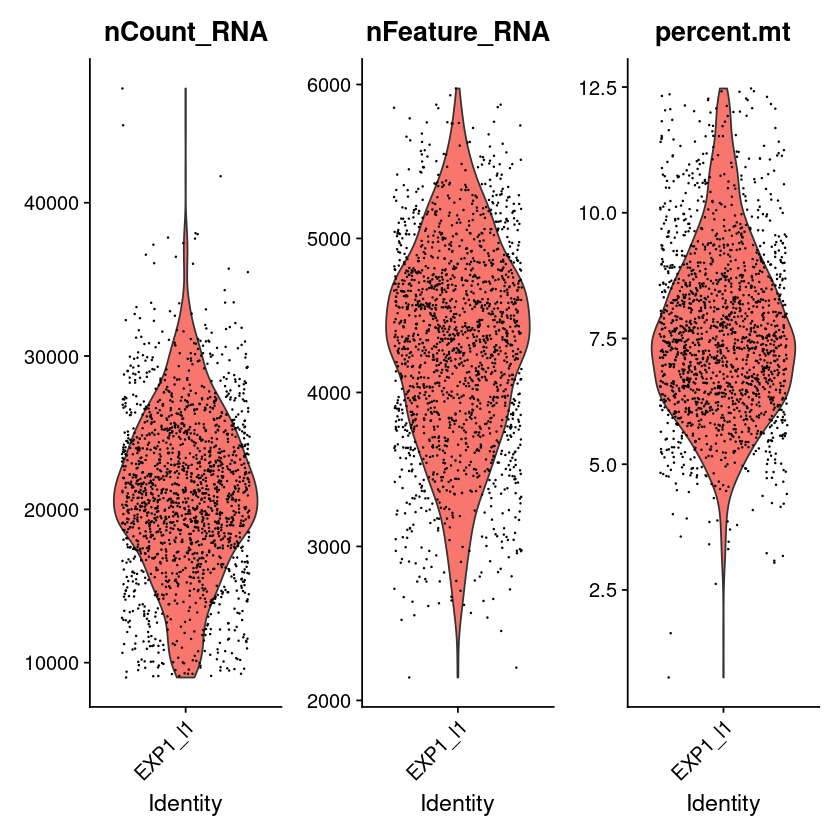

In [107]:
mono1 <- subset(mono, subset = 
                nFeature_RNA >= deadcell_nF_lowercutoff & 
                nFeature_RNA <= deadcell_nF_uppercutoff & 
                nCount_RNA >= deadcell_nC_lowercutoff &
                percent.mt <= deadcell_mt_cutoff) #nCount_RNA >= 1000 &
mono1
VlnPlot(mono1, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), group.by = "orig.ident") 

mono = mono1